In [51]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [53]:
# 잡플래닛 크롤링 함수
def jobplanet_job(result):
    # url 검색 키워드
    keywords = ['백엔드', '프론트엔드', '클라우드', '게임', '네트워크', '보안']

    wd = webdriver.Chrome()
    wd.maximize_window() # 사이트 창 크기 최대화해서 오류를 방지

    for keyword in keywords:
        url = f"https://www.jobplanet.co.kr/search/job?query={keyword}"

        wd.get(url)
        time.sleep(2)

        try:
            for i in range(15):
                wd.execute_script("window.scrollTo(0, document.body.scrollHeight);") # 잡플래닛 페이지는 페이지 구분 없이 계속 내려가기 때문에 페이지 맨 아래로 스크롤
                time.sleep(1)
            
            html = wd.page_source
            soup = BeautifulSoup(html, 'html.parser')

            # 잡플래닛의 기술 스택이 있는 html 태그를 찾아서 리스트에 저장
            job_stack_list = soup.find_all('span', class_='mt-[7px] inline-block w-full truncate text-small1 text-gray-500') 

            job_stack_result = [] 

            for job_stack in job_stack_list:
                text = job_stack.text

                if ',' in text:
                    parts = text.split(',')

                    if '년' in parts[0]: # 맨 앞에 ~년 같은 불필요한 요소가 있어서 제거
                        stacks = parts[1:]
                    else:
                        stacks = parts

                    for s in stacks:
                        if s.strip():
                            job_stack_result.append(s.strip()) # 공백과 '년'을 제거한 html 태그의 기술 스택을 추출해 job_stack_result에 저장
            
            job_stack_count = {}
            for count in job_stack_result:
                if count in job_stack_count:
                    job_stack_count[count] = job_stack_count[count] + 1
                else:
                    job_stack_count[count] = 1
            
            # tech : 기술 스택 , count_num : 빈도수
            for tech, count_num, in job_stack_count.items():
                result.append([keyword, tech, count_num])

        except:
            continue
    
    return

In [54]:
# 잡플래닛 크롤링 시각화 함수
def visualize_stack(df):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 크롤링한 데이터에서 빈도수를 추출 => to_numeric을 써서 문자열을 숫자로 변환
    df['빈도수'] = pd.to_numeric(df['빈도수'], errors='coerce').fillna(0)

    # 기술 스택에서 html 태그 그대로 추출하면 한글이 자꾸 추출됨 -> 한글이 있는 행은 제거
    df = df[~df['직무별 스택'].str.contains('[가-힣]',na=False)]

    result = []
    for job in df['직무'].unique(): # 직무 열에서 중복을 제거 -> 각각의 값만 추출

        #카테고리에 있는 직무와 비교해서 해당 직무 데이터만 추출후 가장 큰 값을 선택해서 상위 10개 추출
        stack_by_top = df[df['직무'] == job].nlargest(10, '빈도수')
        result.append(stack_by_top)
    
    df_filtered = pd.concat(result)
    
    pivot = df_filtered.pivot_table(values='빈도수', index='직무', columns='직무별 스택', fill_value=0)

    plt.figure(figsize=(20, 10))
    sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd' , linewidths=0.3)

    plt.title('직무별 기술 스택')
    plt.xlabel('기술 스택')
    plt.ylabel('직무')
    plt.xticks(rotation=50)
    plt.yticks(rotation=30)
    
    plt.tight_layout()

    plt.show()

In [55]:
def main():
    result = []

    jobplanet_job(result)

    jobplanet_df = pd.DataFrame(result, columns=['직무', '직무별 스택', '빈도수'])

    jobplanet_df.to_csv('C:/Users/wjdah/vscode-workspace/CareerRoute/assets/jobplanet/jobplanet_stack.csv', encoding='utf-8-sig', index='False')

    visualize_stack(jobplanet_df)

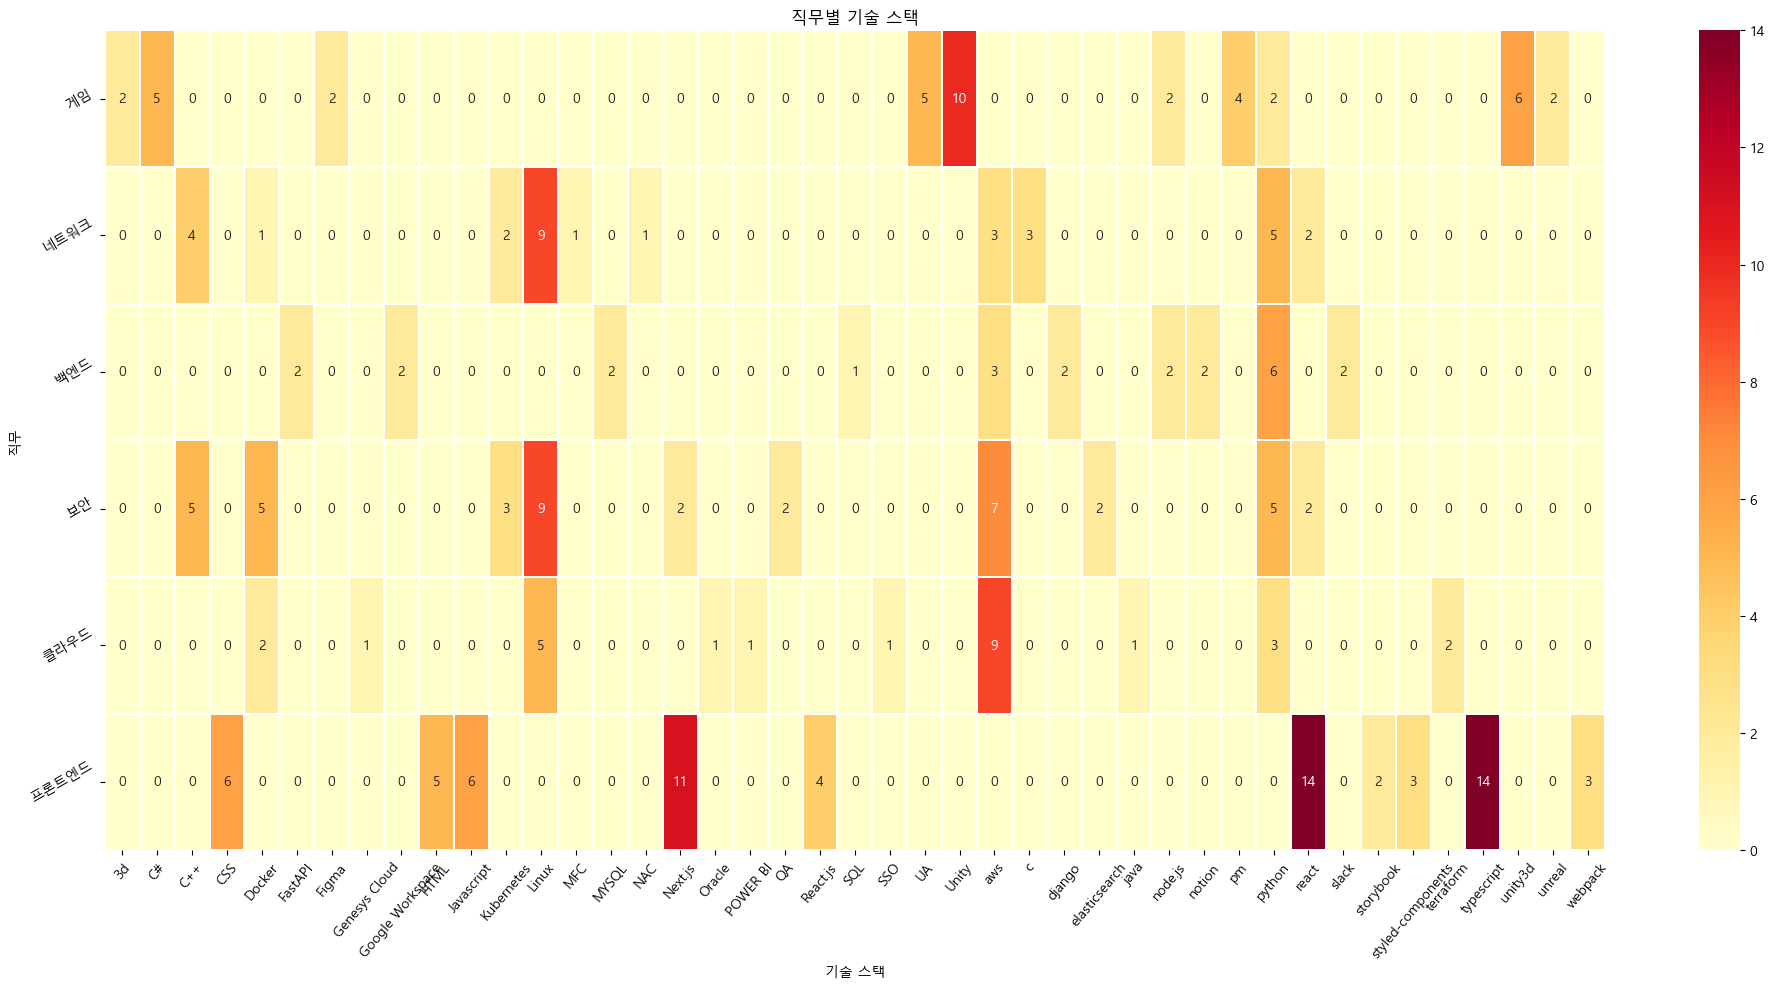

In [56]:
if __name__ == '__main__':
    main()